Only the GFA dataset contains a land cover attribute. This notebook 1) processes the MODIS data into GeoTiff files, 2) evaluates how well the MODIS Land Cover product can be used to predict the given categories in the USA, and 3) use the MODIS product to assign land cover categories to fires in other datasets.

### Convert MODIS data into GeoTIFF files

In [1]:
import os
import subprocess
import re
import geopandas as gpd
import rasterio
import rasterio.mask
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
# REPLACE WITH PATH TO MODIS FILES
modis_folder = "/Users/lukevonkapff/wildfires/MODIS_USA"
tif_folder = os.path.join(modis_folder, "GeoTIFF")
os.makedirs(tif_folder, exist_ok=True)

def get_lc_type1_subdataset(hdf_path):
    """Return the LC_Type1 subdataset string using gdalinfo output."""
    result = subprocess.run(
        ["gdalinfo", hdf_path],
        capture_output=True,
        text=True,
        check=True
    )
    for line in result.stdout.splitlines():
        if "LC_Type1" in line and "SUBDATASET" in line:
            return line.split("=")[1].strip()
    raise RuntimeError(f"LC_Type1 subdataset not found in {hdf_path}")

for fname in os.listdir(modis_folder):
    if fname.endswith(".hdf"):
        hdf_path = os.path.join(modis_folder, fname)
        base = os.path.splitext(fname)[0]
        tif_path = os.path.join(tif_folder, f"{base}_LC_Type1.tif")

        if os.path.exists(tif_path):
            continue

        subdataset = get_lc_type1_subdataset(hdf_path)

        cmd = ["gdal_translate", subdataset, tif_path, "-of", "GTiff"]

        print("Converting:", hdf_path)
        subprocess.run(cmd, check=True)

### Use MODIS GeoTIFFs to predict land cover type for each GFA fire in USA (2003-2016) and compare them to given GFA land cover attribute. This predicts the land cover type by finding all MODIS landcover types inside each fire's boundary, then the most common one spatially is defined as that fire's predicted land cover type.

In [3]:
# REPLACE WITH PATH TO GFA DATA
gfa_folder = "/Users/lukevonkapff/wildfires/CMS_GFA/data"
pattern = re.compile(r"Global_fire_atlas_V1_perimeter_\d{4}")

us_bounds = {
    "minx": -125.0,   # west
    "maxx": -66.0,    # east
    "miny": 24.0,     # south
    "maxy": 50.0      # north
}

gfa_all_data = []
for gfa_folder_name in os.listdir(gfa_folder):
    if pattern.match(gfa_folder_name):
        gfa_year = int(re.search(r"\d{4}", gfa_folder_name).group())
        if 2003 <= gfa_year <= 2016:
            gfa_shp_path = os.path.join(
                gfa_folder, gfa_folder_name, gfa_folder_name + ".shp"
            )
            if os.path.exists(gfa_shp_path):
                gfa_gdf = gpd.read_file(gfa_shp_path).set_crs("EPSG:4326")
                gfa_gdf["YEAR"] = gfa_year
                gfa_gdf = gfa_gdf.cx[us_bounds["minx"]:us_bounds["maxx"], us_bounds["miny"]:us_bounds["maxy"]]
                gfa_all_data.append(gfa_gdf)

if gfa_all_data:
    gfa_global = pd.concat(gfa_all_data, ignore_index=True)
else:
    gfa_global = gpd.GeoDataFrame(
        columns=["fire_ID", "geometry", "YEAR", "landcover_s"], crs="EPSG:4326"
    )

print(f"Number of GFA fires in USA (2003-2016): {len(gfa_global)}")

modis_files = [os.path.join(tif_folder, f) for f in os.listdir(tif_folder) if f.endswith(".tif")]
modis_by_year = {}
for f in modis_files:
    match = re.search(r"A(\d{4})", os.path.basename(f))
    if match:
        year = int(match.group(1))
        modis_by_year.setdefault(year, []).append(f)

modis_to_gfa = {
    0: "Water",
    1: "Evergreen Needleleaf forest",
    2: "Evergreen Broadleaf forest",
    3: "Deciduous Needleleaf forest",
    4: "Deciduous Broadleaf forest",
    5: "Mixed forest",
    6: "Closed shrublands",
    7: "Open shrublands",
    8: "Woody savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent wetlands",
    12: "Croplands",
    13: "Urban and built-up",
    14: "Cropland/Natural vegetation mosaic",
    15: "Snow and ice",
    16: "Barren or sparsely vegetated"
}

results = []
for year, fires in gfa_global.groupby("YEAR"):
    if year not in modis_by_year:
        continue

    for modis_file in modis_by_year[year]:
        with rasterio.open(modis_file) as src:
            fires_proj = fires.to_crs(src.crs)

            for idx, fire in fires_proj.iterrows():
                try:
                    out_image, _ = rasterio.mask.mask(src, [fire.geometry], crop=True)
                except ValueError:
                    continue 

                data = out_image[0]
                data = data[(data != src.nodata) & (data != 255)]

                if data.size > 0:
                    mapped = [modis_to_gfa.get(int(val), "Other") for val in data]
                    majority = Counter(mapped).most_common(1)[0][0]
                    results.append({
                        "fire_ID": fire["fire_ID"],
                        "year": fire["YEAR"],
                        "gfa_class": fire.get("landcover_s", "Other"),
                        "modis_class": majority,
                        "geometry": fire.geometry
                    })

results_df = gpd.GeoDataFrame(results, crs="EPSG:4326")
results_df["area_km2"] = results_df.geometry.area / 1e6

gfa_classified = results_df[results_df["area_km2"] >= 4].copy()

print(f"Fires > 4 km²: {len(gfa_classified)}")
gfa_classified.head()

/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2010/Global_fire_atlas_V1_perimeter_2010.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Number of GFA fires in USA (2003-2016): 154917
Fires > 4 km²: 19839


/var/folders/84/1wml2kcs3c97cl37plzqv0kh0000gn/T/ipykernel_6227/525177044.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  results_df["area_km2"] = results_df.geometry.area / 1e6


,fire_ID,year,gfa_class,modis_class,geometry,area_km2
5,26341,2003,Evergreen Needleleaf forest,Woody savannas,"POLYGON ((-8435534.62982 5559752.59833, -84290...",20.392574
34,26372,2003,Evergreen Needleleaf forest,Woody savannas,"POLYGON ((-8351211.71541 5544463.27869, -83507...",5.795784
35,26373,2003,Evergreen Needleleaf forest,Woody savannas,"POLYGON ((-8246966.35419 5544463.27869, -82441...",13.738155
55,26392,2003,Grasslands,Woody savannas,"POLYGON ((-8400786.17608 5539366.8388, -839985...",6.654419
86,26390,2003,Evergreen Needleleaf forest,Woody savannas,"POLYGON ((-8562482.31414 5539830.15152, -85606...",248.360085


In [23]:
def evaluate_modis_against_gfa(df, ref_col="gfa_class", pred_col="modis_class"):
    """
    Evaluate how well MODIS classification (prediction) matches GFA classification (ground truth).

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame (e.g., gfa_classified) containing GFA and MODIS classes.
    ref_col : str, default="gfa_class"
        Column name for the reference / ground-truth classification (GFA).
    pred_col : str, default="modis_class"
        Column name for the predicted classification (MODIS).

    Returns
    -------
    pd.DataFrame
        Summary table with land_cover, n_samples, sensitivity, and specificity per class.
    """

    # 8 GFA / MODIS biome categories of interest
    valid_classes = [
        "Deciduous Broadleaf forest",
        "Evergreen Broadleaf forest",
        "Mixed forest",
        "Savannas",
        "Woody savannas",
        "Evergreen Needleleaf forest",
        "Open shrublands",
        "Grasslands"
    ]

    # Keep only samples within these classes
    df = df[df[ref_col].isin(valid_classes) & df[pred_col].isin(valid_classes)].copy()
    if df.empty:
        print("No valid samples remain after filtering by the 8 target classes.")
        return pd.DataFrame()

    df[ref_col] = df[ref_col].astype(str).str.strip()
    df[pred_col] = df[pred_col].astype(str).str.strip()
    all_classes = sorted(set(valid_classes) & set(df[ref_col].unique()) & set(df[pred_col].unique()))
    cm = confusion_matrix(df[ref_col], df[pred_col], labels=all_classes)
    cm_df = pd.DataFrame(cm, index=all_classes, columns=all_classes)

    results = []
    for i, cls in enumerate(all_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        n_samples = cm[i, :].sum()

        results.append({
            "land_cover": cls,
            "n_samples": n_samples,
            "sensitivity": sensitivity,
            "specificity": specificity
        })

    summary = pd.DataFrame(results).sort_values("land_cover").reset_index(drop=True)

    print(f"Evaluated {len(df)} samples across {len(all_classes)} biome classes.")
    return summary

def evaluate_modis_reliability(df, ref_col="modis_class", pred_col="gfa_class"):
    """
    Evaluate how reliable MODIS biome predictions are against GFA ground truth.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing both MODIS and GFA classifications.
    ref_col : str, default="modis_class"
        Column name for the MODIS-predicted classification.
    pred_col : str, default="gfa_class"
        Column name for the GFA ground-truth classification.

    Returns
    -------
    pd.DataFrame
        Summary table with precision, recall, specificity, F1 score, and sample counts per class.
    """

    valid_classes = [
        "Deciduous Broadleaf forest",
        "Evergreen Broadleaf forest",
        "Mixed forest",
        "Savannas",
        "Woody savannas",
        "Evergreen Needleleaf forest",
        "Open shrublands",
        "Grasslands"
    ]

    # Filter to just the 8 target classes
    df = df[df[ref_col].isin(valid_classes) & df[pred_col].isin(valid_classes)].copy()
    if df.empty:
        print("No valid samples remain after filtering by the 8 target classes.")
        return pd.DataFrame()

    df[ref_col] = df[ref_col].astype(str).str.strip()
    df[pred_col] = df[pred_col].astype(str).str.strip()
    all_classes = sorted(set(valid_classes) & set(df[ref_col].unique()) & set(df[pred_col].unique()))
    cm = confusion_matrix(df[ref_col], df[pred_col], labels=all_classes)
    cm_df = pd.DataFrame(cm, index=all_classes, columns=all_classes)

    results = []
    for i, cls in enumerate(all_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        recall = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan
        n_samples = cm[i, :].sum()

        results.append({
            "land_cover": cls,
            "n_predicted_samples": n_samples,
            "precision": precision,
            "recall": recall,
            "specificity": specificity,
            "f1_score": f1
        })

    summary = pd.DataFrame(results).sort_values("land_cover").reset_index(drop=True)

    print(f"Evaluated {len(df)} samples across {len(all_classes)} biome classes.")
    return summary


summary = evaluate_modis_against_gfa(gfa_classified)
summary2 = evaluate_modis_reliability(gfa_classified)
summary

✅ Evaluated 12635 samples across 8 biome classes.
✅ Evaluated 12635 samples across 8 biome classes.


,land_cover,n_samples,sensitivity,specificity
0,Deciduous Broadleaf forest,249,0.899598,0.970128
1,Evergreen Broadleaf forest,235,0.808511,0.980887
2,Evergreen Needleleaf forest,1261,0.360825,0.991032
3,Grasslands,5163,0.955646,0.858940
4,Mixed forest,1395,0.132616,0.998843
5,Open shrublands,1191,0.376994,0.998165
6,Savannas,50,0.180000,0.844497
7,Woody savannas,3091,0.444193,0.888726


In [4]:
merge_map = {
    "Cropland/Natural vegetation mosaic": "Croplands",
    "Permanent wetlands": "Other",
    "Snow and ice": "Other",
    "Water": "Other",
    "Other": "Other"   
}

gfa_classified["modis_class"] = gfa_classified["modis_class"].replace(merge_map)
gfa_classified["gfa_class"] = gfa_classified["gfa_class"].replace(merge_map)

output_path = "../data/gfa_2003_2016_usa_classified_timevarying.shp"
gfa_classified.to_file(output_path)
print(f"Saved GeoDataFrame to {output_path}")

/var/folders/84/1wml2kcs3c97cl37plzqv0kh0000gn/T/ipykernel_6227/3115509413.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gfa_classified.to_file(output_path)
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'modis_class' to 'modis_clas'
  ogr_write(


Saved GeoDataFrame to ../data/gfa_2003_2016_usa_classified_timevarying.shp


This confusion matrix compares the given vs. predicted values in the categorical "land cover type" attribute. 

In [5]:
confusion = pd.crosstab(gfa_classified["gfa_class"], gfa_classified["modis_class"])
confusion

modis_class,Barren or sparsely vegetated,Closed shrublands,Croplands,Deciduous Broadleaf forest,Evergreen Broadleaf forest,Evergreen Needleleaf forest,Grasslands,Mixed forest,Open shrublands,Other,Savannas,Urban and built-up,Woody savannas
gfa_class,,,,,,,,,,,,,
Barren or sparsely vegetated,27,0,0,0,0,0,3,0,7,3,2,0,0
Closed shrublands,0,32,0,0,0,0,18,0,2,0,21,0,24
Croplands,0,1,6086,4,0,0,138,1,1,4,238,0,41
Deciduous Broadleaf forest,0,0,1,224,0,0,1,0,0,0,13,0,11
Evergreen Broadleaf forest,0,0,0,2,190,14,0,0,0,0,2,0,27
Evergreen Needleleaf forest,0,1,0,0,18,455,226,2,0,4,54,0,506
Grasslands,6,2,295,1,0,6,4934,1,19,7,140,2,62
Mixed forest,0,0,3,298,174,62,15,185,0,9,214,0,447
Open shrublands,1,82,38,0,0,1,581,0,449,2,155,0,5


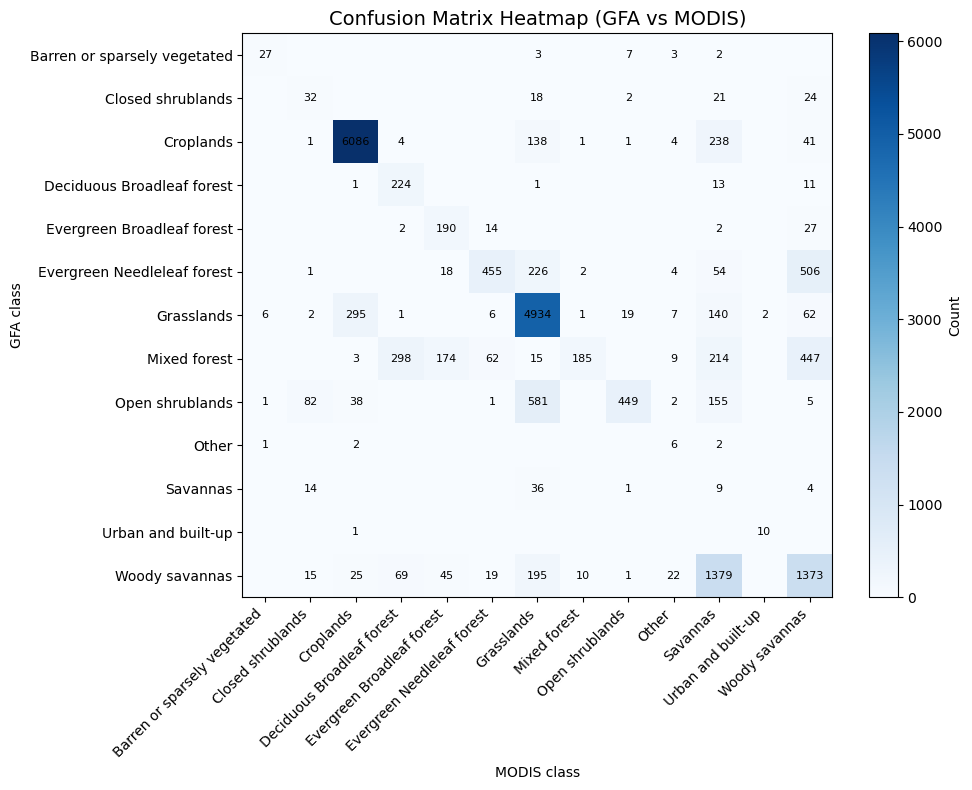

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(confusion, cmap="Blues", aspect="auto")
plt.xticks(range(len(confusion.columns)), confusion.columns, rotation=45, ha="right")
plt.yticks(range(len(confusion.index)), confusion.index)

plt.colorbar(label="Count")
plt.title("Confusion Matrix Heatmap (GFA vs MODIS)", fontsize=14)
plt.xlabel("MODIS class")
plt.ylabel("GFA class")

for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        value = confusion.iat[i, j]
        if value > 0:
            plt.text(j, i, str(value), ha="center", va="center", fontsize=8, color="black")

plt.tight_layout()
plt.show()

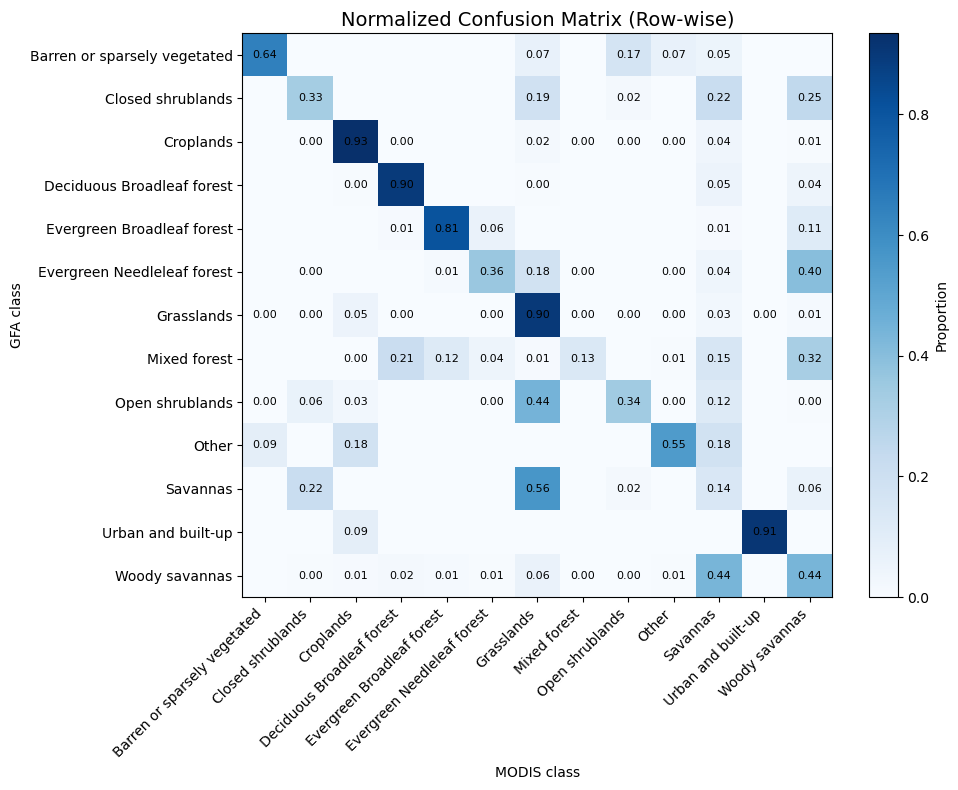

In [7]:
confusion_normalized = confusion.div(confusion.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
plt.imshow(confusion_normalized, cmap="Blues", aspect="auto")

plt.xticks(range(len(confusion.columns)), confusion.columns, rotation=45, ha="right")
plt.yticks(range(len(confusion.index)), confusion.index)

plt.colorbar(label="Proportion")
plt.title("Normalized Confusion Matrix (Row-wise)", fontsize=14)
plt.xlabel("MODIS class")
plt.ylabel("GFA class")

for i in range(confusion_normalized.shape[0]):
    for j in range(confusion_normalized.shape[1]):
        value = confusion_normalized.iat[i, j]
        if value > 0:
            plt.text(j, i, f"{value:.2f}", ha="center", va="center", fontsize=8, color="black")

plt.tight_layout()
plt.show()

In [8]:
true_labels = []
pred_labels = []

for gfa_class in confusion.index:
    for modis_class in confusion.columns:
        count = confusion.loc[gfa_class, modis_class]
        true_labels.extend([gfa_class] * count)
        pred_labels.extend([modis_class] * count)

print("=== Summary Statistics ===")
print("Accuracy:", accuracy_score(true_labels, pred_labels))
print("Weighted F1:", f1_score(true_labels, pred_labels, average="weighted"))
print(classification_report(true_labels, pred_labels))

=== Summary Statistics ===
Accuracy: 0.7046726145471042
Weighted F1: 0.7179597178845741
                              precision    recall  f1-score   support

Barren or sparsely vegetated       0.77      0.64      0.70        42
           Closed shrublands       0.22      0.33      0.26        97
                   Croplands       0.94      0.93      0.94      6514
  Deciduous Broadleaf forest       0.37      0.90      0.53       250
  Evergreen Broadleaf forest       0.44      0.81      0.57       235
 Evergreen Needleleaf forest       0.82      0.36      0.50      1266
                  Grasslands       0.80      0.90      0.85      5475
                Mixed forest       0.93      0.13      0.23      1407
             Open shrublands       0.94      0.34      0.50      1314
                       Other       0.11      0.55      0.18        11
                    Savannas       0.00      0.14      0.01        64
          Urban and built-up       0.83      0.91      0.87        11
 

So, MODIS classifies fires by land cover type with relatively high accuracy. 

### Confirm that this prediction accuracy exists across the data's temporal range...

/var/folders/84/1wml2kcs3c97cl37plzqv0kh0000gn/T/ipykernel_6227/1126948236.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


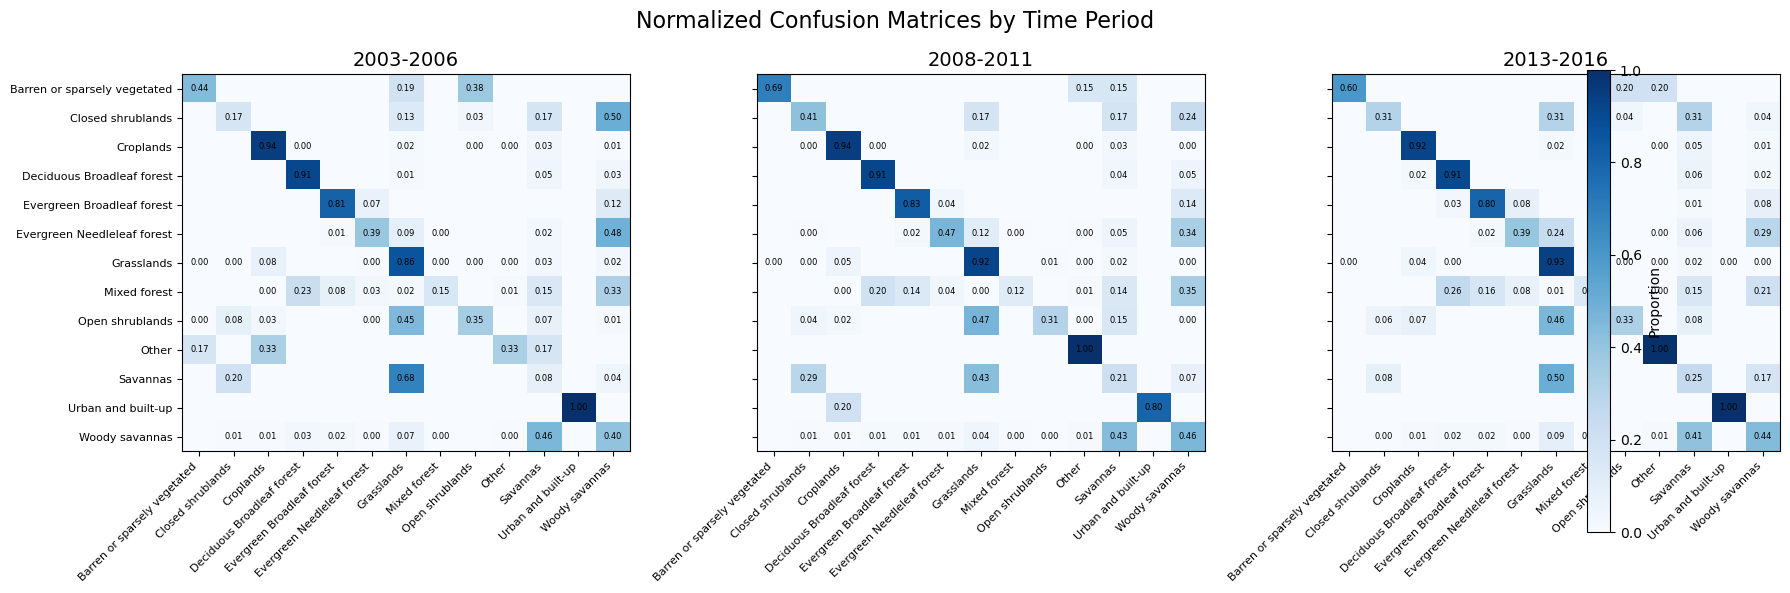


=== 2003-2006 ===
Accuracy: 0.696
Weighted Precision: 0.797
Weighted Recall: 0.696
Weighted F1: 0.711

=== 2008-2011 ===
Accuracy: 0.719
Weighted Precision: 0.828
Weighted Recall: 0.719
Weighted F1: 0.731

=== 2013-2016 ===
Accuracy: 0.726
Weighted Precision: 0.829
Weighted Recall: 0.726
Weighted F1: 0.740


In [9]:
periods = {
    "2003-2006": (2003, 2006),
    "2008-2011": (2008, 2011),
    "2013-2016": (2013, 2016)
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
metrics = {}

for ax, (label, (start, end)) in zip(axes, periods.items()):
    subset = gfa_classified[(gfa_classified["year"] >= start) & (gfa_classified["year"] <= end)]
    confusion = pd.crosstab(subset["gfa_class"], subset["modis_class"])
    confusion_normalized = confusion.div(confusion.sum(axis=1), axis=0).fillna(0)

    im = ax.imshow(confusion_normalized, cmap="Blues", aspect="auto")
    ax.set_title(label, fontsize=14)
    ax.set_xticks(range(len(confusion.columns)))
    ax.set_xticklabels(confusion.columns, rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(len(confusion.index)))
    ax.set_yticklabels(confusion.index, fontsize=8)

    for i in range(confusion_normalized.shape[0]):
        for j in range(confusion_normalized.shape[1]):
            value = confusion_normalized.iat[i, j]
            if value > 0:
                ax.text(j, i, f"{value:.2f}", ha="center", va="center", fontsize=6, color="black")

    true_labels, pred_labels = [], []
    for gfa_class in confusion.index:
        for modis_class in confusion.columns:
            count = confusion.loc[gfa_class, modis_class]
            true_labels.extend([gfa_class] * count)
            pred_labels.extend([modis_class] * count)

    if true_labels:
        metrics[label] = {
            "accuracy": accuracy_score(true_labels, pred_labels),
            "precision_weighted": precision_score(true_labels, pred_labels, average="weighted", zero_division=0),
            "recall_weighted": recall_score(true_labels, pred_labels, average="weighted", zero_division=0),
            "f1_weighted": f1_score(true_labels, pred_labels, average="weighted", zero_division=0),
            "report": classification_report(true_labels, pred_labels, zero_division=0)
        }
    else:
        metrics[label] = None

fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04, label="Proportion")
plt.suptitle("Normalized Confusion Matrices by Time Period", fontsize=16)
plt.tight_layout()
plt.show()

for label, m in metrics.items():
    print(f"\n=== {label} ===")
    if m:
        print(f"Accuracy: {m['accuracy']:.3f}")
        print(f"Weighted Precision: {m['precision_weighted']:.3f}")
        print(f"Weighted Recall: {m['recall_weighted']:.3f}")
        print(f"Weighted F1: {m['f1_weighted']:.3f}")
    else:
        print("No data available for this period.")

Similar performance across temporal range!